# Imports



In [45]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from scipy.ndimage import binary_dilation
import matplotlib.patches as mpatches

In [46]:
# plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Data & Setup

In [47]:
data_dir = "../data/raw/Task07_Pancreas/imagesTr"
label_dir = "../data/raw/Task07_Pancreas/labelsTr"

# Understand Raw Data

In [48]:
# first sample
sample_filename = "pancreas_001.nii.gz"
img = nib.load(os.path.join(data_dir, sample_filename)) # lazy loading
label = nib.load(os.path.join(label_dir, sample_filename)) # lazy loading

In [49]:
# to numpy 
image_data = img.get_fdata() 
label_data = label.get_fdata()

In [50]:
# metadata
header = img.header
spacing = header.get_zooms()

In [51]:
# Specs
print(f"Dims: {image_data.shape}")
print(f"Voxel distance: {spacing}")
print(f"intensity (HU): {np.min(image_data)} bis {np.max(image_data)}")

Dims: (512, 512, 110)
Voxel distance: (np.float32(0.644531), np.float32(0.644531), np.float32(2.5))
intensity (HU): -1024.0 bis 3071.0


# Visualize Data

In [52]:
# mid slice
slice_idx = image_data.shape[2] // 2

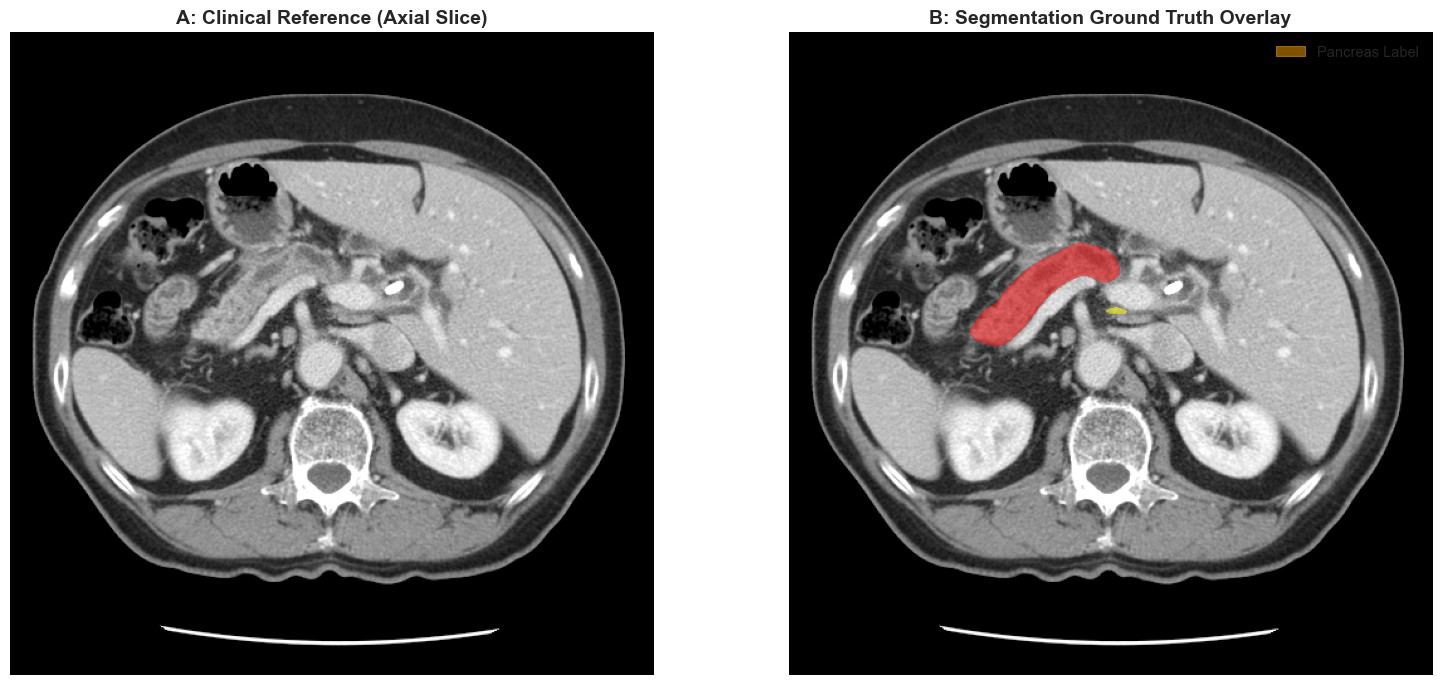

In [53]:
def plot_initial_check(image_data, label_data, slice_idx):
    # 1. Windowing 
    img_windowed = np.clip(image_data[:, :, slice_idx], -160, 240)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 7), facecolor='white')
    
    # Plot A: ct
    ax[0].imshow(img_windowed.T, cmap='gray', origin='lower')
    ax[0].set_title("A: Clinical Reference (Axial Slice)", fontsize=14, fontweight='bold')
    ax[0].axis('off')
    
    # Plot B:  Overlay (CT + seg mask)
    ax[1].imshow(img_windowed.T, cmap='gray', origin='lower')
    
    masked_label = np.ma.masked_where(label_data[:, :, slice_idx] == 0, 
                                     label_data[:, :, slice_idx])
    
    ax[1].imshow(masked_label.T, cmap='autumn', origin='lower', alpha=0.5)
    ax[1].set_title("B: Segmentation Ground Truth Overlay", fontsize=14, fontweight='bold')
    ax[1].axis('off')
    
    # legend
    relic = mpatches.Patch(color='orange', label='Pancreas Label', alpha=0.5)
    ax[1].legend(handles=[relic], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_initial_check(image_data, label_data, slice_idx)

# Further Analysis

### Intensity (Hounsfield Units)

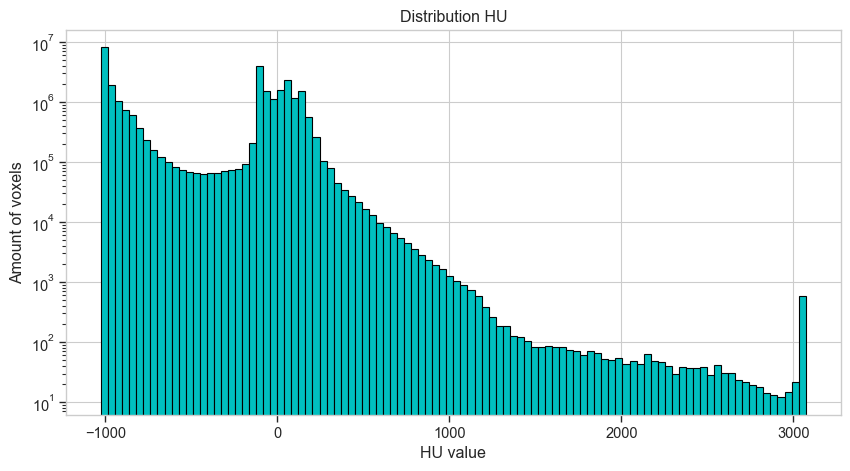

In [54]:
plt.figure(figsize=(10, 5))
plt.hist(image_data.flatten(), bins=100, color='c', edgecolor='k')
plt.title("Distribution HU")
plt.xlabel("HU value")
plt.ylabel("Amount of voxels")
plt.yscale('log') # for better plot
plt.grid(True)
plt.show()

interpretation:
- peak -1000: air
- peak 0: water/ fat
- $>400$: bones/ calcium

pancreas:
- typically between 30 & 150 HU 

## simple Windowing

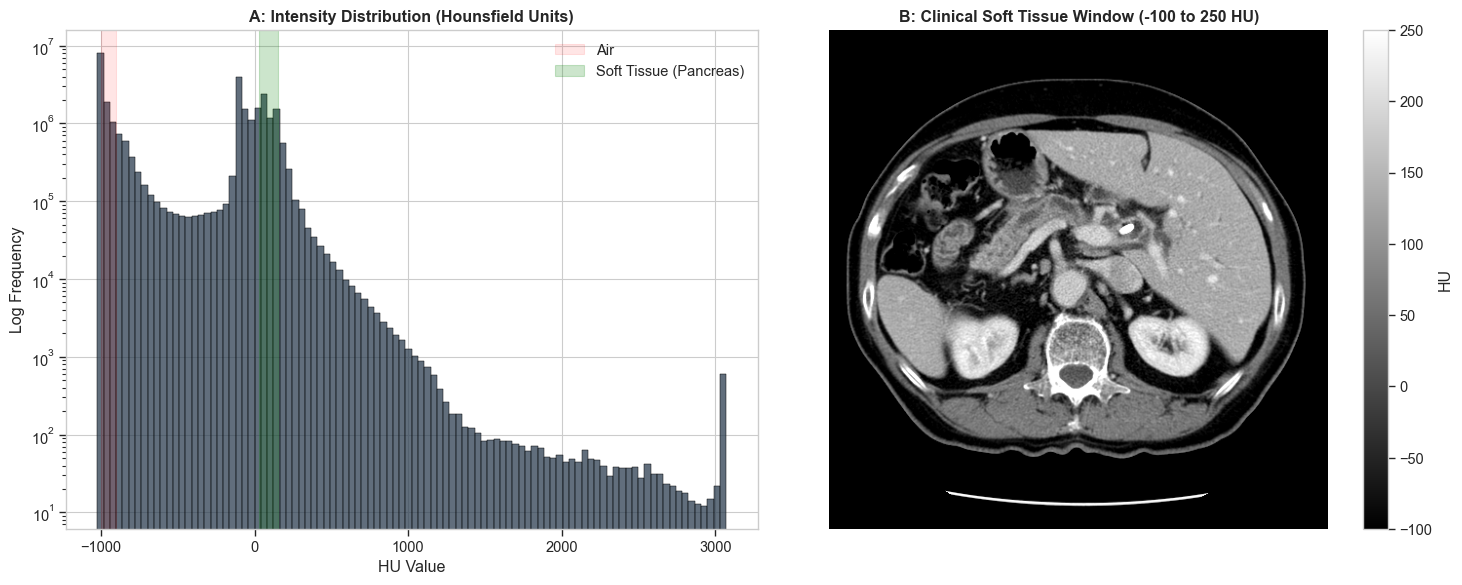

In [55]:
def plot_histogram_and_window(image_data):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogramm
    sns.histplot(image_data.flatten(), bins=100, ax=ax[0], color="#2c3e50")
    ax[0].set_yscale('log')
    ax[0].set_title("A: Intensity Distribution (Hounsfield Units)", fontweight='bold')
    ax[0].set_xlabel("HU Value")
    ax[0].set_ylabel("Log Frequency")
    
    # Annotate important tissues
    ax[0].axvspan(-1000, -900, color='red', alpha=0.1, label='Air')
    ax[0].axvspan(30, 150, color='green', alpha=0.2, label='Soft Tissue (Pancreas)')
    ax[0].legend()

    # Windowed Image (Soft Tissue Window)
    windowed = np.clip(image_data, -100, 250) 
    mid_slice = image_data.shape[2] // 2
    im = ax[1].imshow(windowed[:, :, mid_slice].T, cmap='gray', origin='lower')
    ax[1].set_title("B: Clinical Soft Tissue Window (-100 to 250 HU)", fontweight='bold')
    ax[1].axis('off')
    plt.colorbar(im, ax=ax[1], label="HU")
    
    plt.tight_layout()
    plt.show()

plot_histogram_and_window(image_data)

## multi view

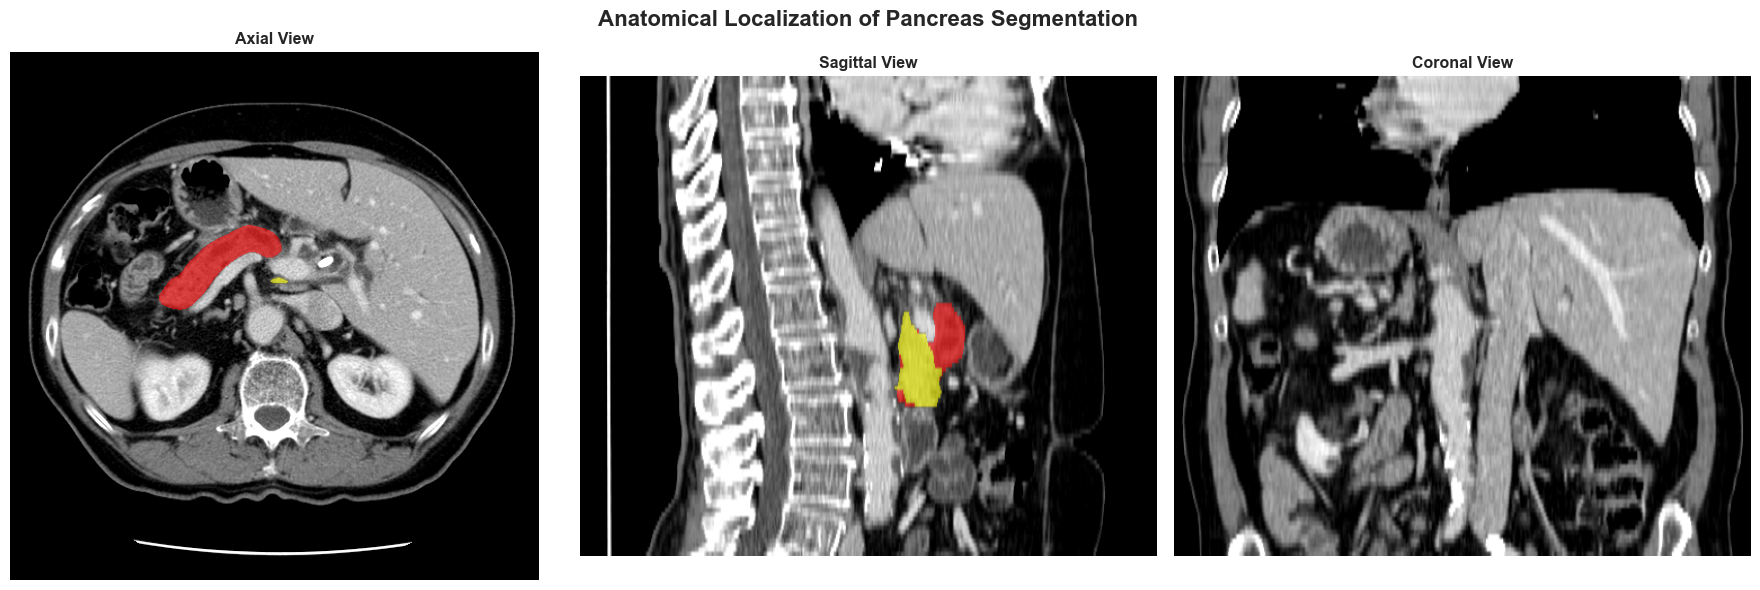

In [56]:
def plot_multi_view_segmentation(img_data, label_data, slice_indices=None):
    """Visualisiert das pancreas-Segment in allen drei Ebenen."""
    # windowing
    img_w = np.clip(img_data, -100, 250)
    
    if slice_indices is None:
        slice_indices = [s // 2 for s in img_data.shape]
        
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    titles = ['Axial View', 'Sagittal View', 'Coronal View']
    
    # Axial: (X, Y, slice)
    axes[0].imshow(img_w[:, :, slice_indices[2]].T, cmap='gray', origin='lower')
    axes[0].imshow(np.ma.masked_where(label_data[:, :, slice_indices[2]] == 0, 
                   label_data[:, :, slice_indices[2]]).T, cmap='autumn', alpha=0.6, origin='lower')
    
    # Sagittal: (slice, Y, Z)
    axes[1].imshow(img_w[slice_indices[0], :, :].T, cmap='gray', origin='lower', aspect=spacing[2]/spacing[1])
    axes[1].imshow(np.ma.masked_where(label_data[slice_indices[0], :, :] == 0, 
                   label_data[slice_indices[0], :, :]).T, cmap='autumn', alpha=0.6, origin='lower', aspect=spacing[2]/spacing[1])
    
    # Coronal: (X, slice, Z)
    axes[2].imshow(img_w[:, slice_indices[1], :].T, cmap='gray', origin='lower', aspect=spacing[2]/spacing[0])
    axes[2].imshow(np.ma.masked_where(label_data[:, slice_indices[1], :] == 0, 
                   label_data[:, slice_indices[1], :]).T, cmap='autumn', alpha=0.6, origin='lower', aspect=spacing[2]/spacing[0])

    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontweight='bold')
        ax.axis('off')
        
    plt.suptitle(f"Anatomical Localization of Pancreas Segmentation", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_multi_view_segmentation(image_data, label_data)

## isolated pancreas

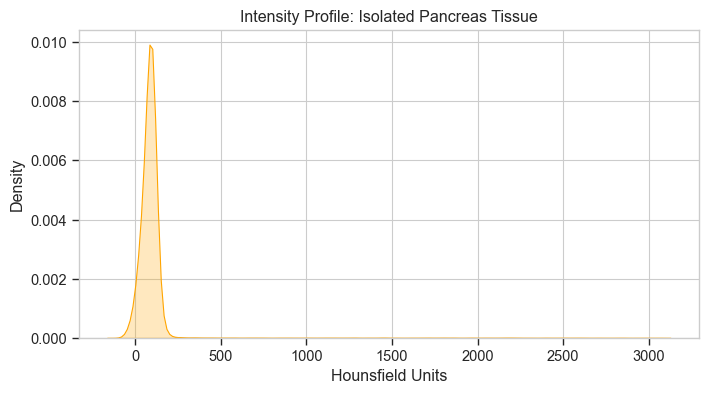

Averaged Density pancreas: 95.06 HU


In [57]:
# isolating pancreas voxels
pancreas_voxels = image_data[label_data > 0]

plt.figure(figsize=(8, 4))
sns.kdeplot(pancreas_voxels, fill=True, color="orange")
plt.title("Intensity Profile: Isolated Pancreas Tissue")
plt.xlabel("Hounsfield Units")
plt.show()

print(f"Averaged Density pancreas: {np.mean(pancreas_voxels):.2f} HU")

# Advanced analysis for machine learning

In [58]:
def deep_expert_analysis(image_data, label_data, spacing):
    # 1. Volume Calculation
    voxel_vol = np.prod(spacing)
    pancreas_vol = np.sum(label_data > 0) * voxel_vol / 1000 # in ml
    total_vol = np.prod(image_data.shape) * voxel_vol / 1000
    
    # 2. Class Imbalance
    ratio = (np.sum(label_data > 0) / np.prod(image_data.shape)) * 100
    
    print(f"--- Clinical Data Report ---")
    print(f"Pancreas Volume: {pancreas_vol:.2f} ml")
    print(f"Volume Ratio: {ratio:.4f}% of total scan")
    print(f"Voxel Anisotropy (Z/X): {spacing[2]/spacing[0]:.2f}")
    
    if ratio < 0.5:
        print("Warning: Extreme Class Imbalance detected. Dice Loss recommended.")
    if spacing[2]/spacing[0] > 1.5:
        print("Warning: High Anisotropy. Isotropic Resampling required.")

deep_expert_analysis(image_data, label_data, spacing)

--- Clinical Data Report ---
Pancreas Volume: 68.24 ml
Volume Ratio: 0.2279% of total scan
Voxel Anisotropy (Z/X): 3.88


## spatial integrity

Spatial resolution could be direction-dependent.

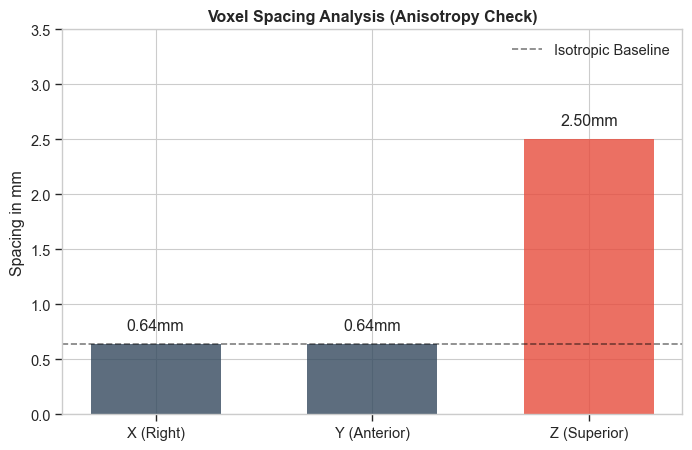

In [59]:
def plot_spatial_anisotropy(spacing):
    axes = ['X (Right)', 'Y (Anterior)', 'Z (Superior)']
    values = spacing
    
    plt.figure(figsize=(8, 5))
    colors = ['#34495e', '#34495e', '#e74c3c'] 
    bars = plt.bar(axes, values, color=colors, alpha=0.8, width=0.6)
    
    plt.title("Voxel Spacing Analysis (Anisotropy Check)", fontweight='bold')
    plt.ylabel("Spacing in mm")
    plt.ylim(0, max(values) + 1)
    
    # Goldstandard-Linie (Isotropie)
    plt.axhline(y=values[0], color='black', linestyle='--', alpha=0.5, label='Isotropic Baseline')
    
    # Annotate values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}mm", ha='center', va='bottom')

    plt.legend()
    plt.show()

plot_spatial_anisotropy(spacing)

interpretation:
- z-axis: significant higher value
- -> layers are thicker than they are wide
- -> spacing for ml algo might be helpful

## Class imbalance 

Test for class imbalance

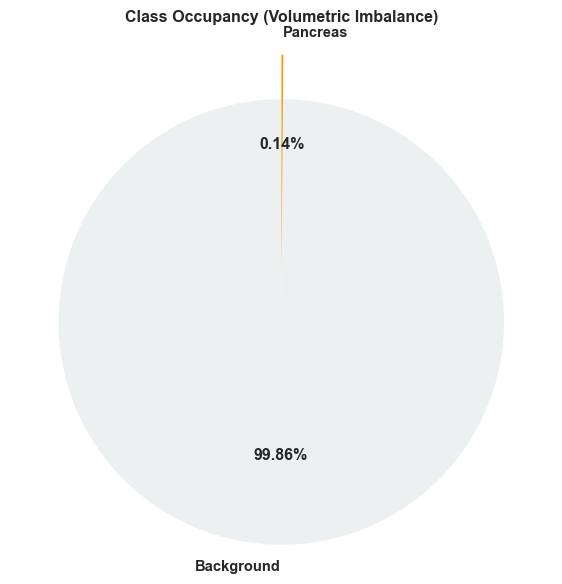

In [60]:
def plot_class_imbalance(label_data):
    counts = np.bincount(label_data.astype(int).ravel())
    # 0 = Background, 1 = Pancreas, (2 = Tumor, falls vorhanden)
    labels = ['Background', 'Pancreas']
    sizes = counts[:2]
    
    fig, ax = plt.subplots(figsize=(7, 7))
    colors = ['#ecf0f1', '#f39c12']
    explode = (0, 0.2) 
    
    ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
           shadow=False, startangle=90, colors=colors, textprops={'weight': 'bold'})
    ax.axis('equal') 
    plt.title("Class Occupancy (Volumetric Imbalance)", fontweight='bold')
    plt.show()

plot_class_imbalance(label_data)

interpretation:
- <0.2%
- -> Loss function adaption

## Boundary Intensity

How do the HU values change at the edge between the pancreas and the surrounding area?

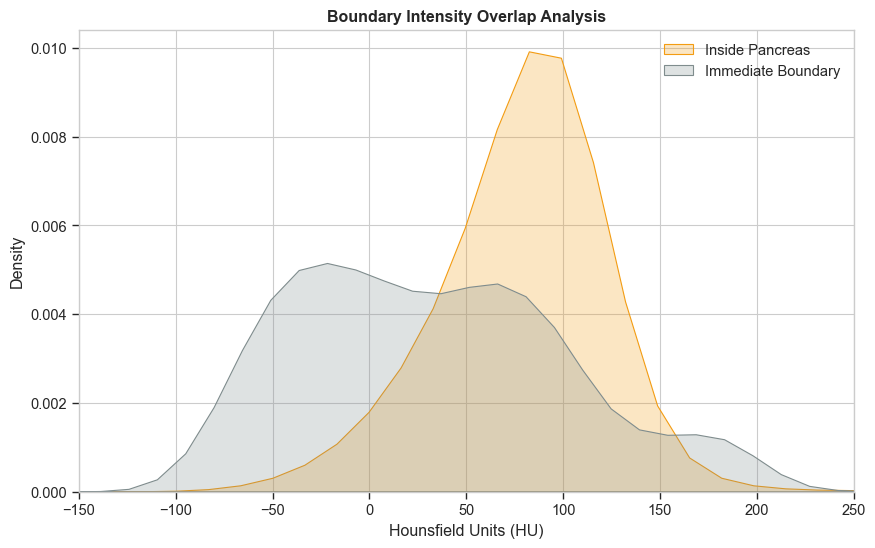

In [61]:

def plot_boundary_characteristics(image_data, label_data):
    kernel = np.ones((3,3,3))
    dilated_mask = binary_dilation(label_data > 0, structure=kernel)
    boundary_mask = dilated_mask ^ (label_data > 0) # XOR 
    
    inside_hu = image_data[label_data > 0]
    boundary_hu = image_data[boundary_mask]
    
    plt.figure(figsize=(10, 6))
    sns.kdeplot(inside_hu, fill=True, label="Inside Pancreas", color="#f39c12")
    sns.kdeplot(boundary_hu, fill=True, label="Immediate Boundary", color="#7f8c8d")
    
    plt.title("Boundary Intensity Overlap Analysis", fontweight='bold')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Density")
    plt.xlim(-150, 250)
    plt.legend()
    plt.show()

plot_boundary_characteristics(image_data, label_data)

interpretation:
- density quite similiar -> advanced ml algos necessary (with spatial context) 
- 